### Spatial Optimization (1): p-Median  Problem

This problem entails the location of p-facilities while minimizing the total weighted distance of servicing all demands. 
Each node has an associated weight that represents the amount of demand at that node.


**Objective function:** Minimizing demand-weighted  summed over all facilities and demand nodes.

**Decision variables:** where to put the facilities and which demand nodes are serviced by which facility location 

**Constraints:**
- Each node is serviced by 1 facility
- A node can be serviced by a facility at a certain location only if there is a facility.
- We must place p facilities
- Each node is either a facility or not. 

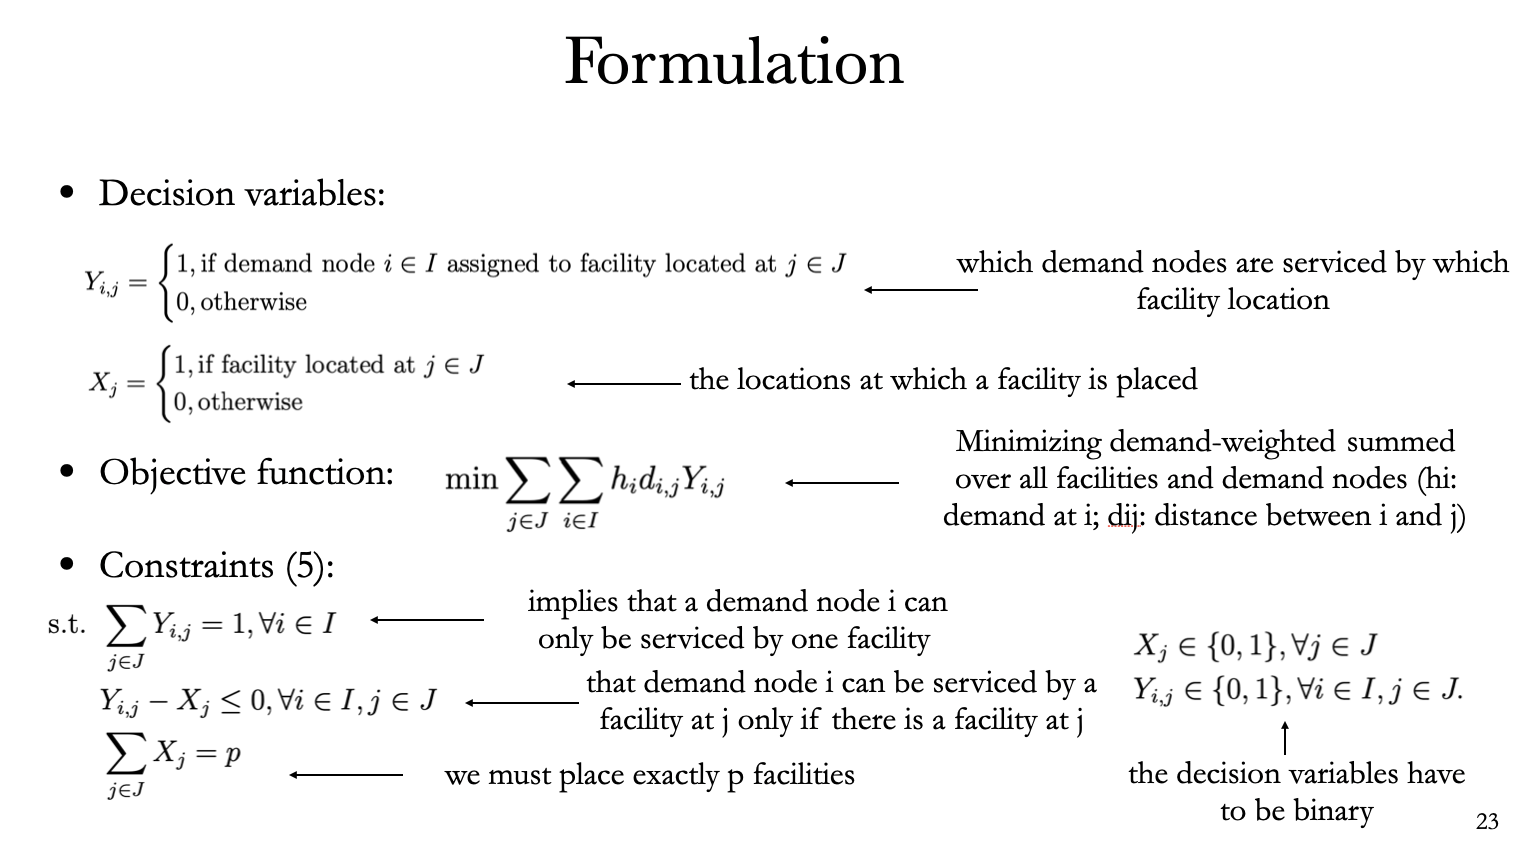

In [1]:
from pulp import *
import numpy as np
import geopandas as gp
from scipy.spatial.distance import cdist

import libpysal as ps
import matplotlib.pyplot as plt

In [39]:
#read a sample shapefile SC一共46个县
SouthCarolina_shp = gp.read_file("./gadm41_USA_shp/gadm41_USA_SC_countries.shp") 


In [40]:
import pandas as pd
# 读取 CSV 文件 
# https://rfa.sc.gov/data-research/population-demographics/census-state-data-center/population-data/population-estimates-counties
csv_data = pd.read_csv('./popestbycounty1020.csv')


In [44]:

# 合并到 SouthCarolina_shp
SouthCarolina_shp['NAME_2'] = SouthCarolina_shp['NAME_2'].str.upper()

SouthCarolina_shp = pd.merge(SouthCarolina_shp, csv_data, left_on='NAME_2', right_on='COUNTY', how='left')

In [45]:

SouthCarolina_shp.dtypes

GID_2                           object
GID_0                           object
COUNTRY                         object
GID_1                           object
NAME_1                          object
NL_NAME_1                       object
NAME_2                          object
VARNAME_2                       object
NL_NAME_2                       object
TYPE_2                          object
ENGTYPE_2                       object
CC_2                            object
HASC_2                          object
geometry                      geometry
COUNTY                          object
JULY 1, 2010\r\nESTIMATES*       int64
JULY 1, 2011\r\nESTIMATES        int64
JULY 1, 2012\r\nESTIMATES        int64
JULY 1, 2013\r\nESTIMATES        int64
JULY 1, 2014\r\nESTIMATES        int64
JULY 1, 2015\r\nESTIMATES        int64
JULY 1, 2016\r\nESTIMATES        int64
JULY 1, 2017\r\nESTIMATES        int64
JULY 1, 2018\r\nESTIMATES        int64
JULY 1, 2019\r\nESTIMATES        int64
2020ESTIMATES            

<Axes: >

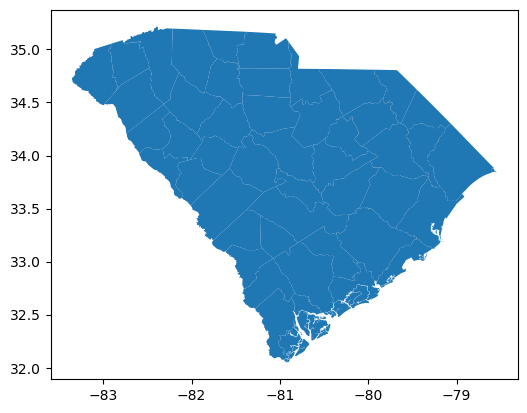

In [46]:
SouthCarolina_shp.plot()

In [47]:
#create a demand and a facilities variable, indicating the indices of each demand and facility.
#demand node: all counties
#facility: we could build facilities in some counties

demand = np.arange(0,46,1)
facilities = np.arange(0,46,1)


In [48]:
#Calculate a distance matrix d_ij (n by n)
coords = list(zip(SouthCarolina_shp.centroid.x,SouthCarolina_shp.centroid.y))

d = cdist(coords,coords) 

/tmp/ipykernel_50705/32761995.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  coords = list(zip(SouthCarolina_shp.centroid.x,SouthCarolina_shp.centroid.y))


In [49]:
d

array([[0.        , 1.06701732, 1.65465887, ..., 0.96017383, 2.79633474,
        1.478662  ],
       [1.06701732, 0.        , 0.62202807, ..., 1.14439272, 1.90810268,
        1.49837824],
       [1.65465887, 0.62202807, 0.        , ..., 1.72095353, 1.74697756,
        1.99328928],
       ...,
       [0.96017383, 1.14439272, 1.72095353, ..., 0.        , 2.17255426,
        0.51940606],
       [2.79633474, 1.90810268, 1.74697756, ..., 2.17255426, 0.        ,
        1.98921587],
       [1.478662  , 1.49837824, 1.99328928, ..., 0.51940606, 1.98921587,
        0.        ]])

In [53]:
#the demand for each county (h_i) is the total populatoion 
h = SouthCarolina_shp['2020ESTIMATES'].values

In [54]:
# declare facilities variables
X = LpVariable.dicts('X_%s',(facilities),cat='Binary')

# declare demand-facility pair variables
Y = LpVariable.dicts('Y_%s_%s', (demand,facilities),cat='Binary') 

In [55]:
#Number of facilities to place
p = 1 #change this and re-run the code.

prob = LpProblem('P_Median_GA', LpMinimize)

In [56]:
# Objective function: Minimizing demand-distance weighted summed over all facilities and demand nodes 
# (h_i: demand at i; d_ij: distance between i and j)

prob += sum(sum(h[i] * d[i][j] * Y[i][j] for j in facilities) for i in demand)

In [57]:
# This constraint indicates we must place exactly p facilities

prob += sum([X[j] for j in facilities]) == p

In [58]:
# This constraint implies that a demand node i can only be serviced by one facility

for i in demand: 
    prob += sum(Y[i][j] for j in facilities) == 1
    

In [59]:
# This constraint implies that that demand node i 
# can be serviced by a facility at j only if there is a facility at j

# It implicitly removes situation when X[j] = 0 but Y[i][j] = 1 
# (node i is served by j but there is no facility at j)

for i in demand:
    for j in facilities: 
        prob +=  Y[i][j] <= X[j]

In [60]:
%%time
# Solve the above problem
prob.solve()

print("Status:", LpStatus[prob.status])

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /home/myubuntu/miniconda3/envs/py312/lib/python3.12/site-packages/pulp/solverdir/cbc/linux/64/cbc /tmp/cdc04db3d1d84752af584d02837e865f-pulp.mps -timeMode elapsed -branch -printingOptions all -solution /tmp/cdc04db3d1d84752af584d02837e865f-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 2168 COLUMNS
At line 14957 RHS
At line 17121 BOUNDS
At line 19284 ENDATA
Problem MODEL has 2163 rows, 2162 columns and 6394 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 6.24445e+06 - 0.08 seconds
Cgl0005I 47 SOS with 2162 members
Cgl0004I processed model has 2163 rows, 2162 columns (2162 integer (2162 of which binary)) and 6394 elements
Cbc0038I Initial state - 0 integers unsatisfied sum - 0
Cbc0038I Solution found of 6.24445e+06
Cbc0038I Before mini branch and bound, 2162 integers at bound fixed and 0 co

In [61]:
# The minimized total demand-distance. The unit is person * meter
print("Objective: ",value(prob.objective))

Objective:  6244448.9869454


In [62]:
# Print the facility node.
rslt=[]
for v in prob.variables():
    subV = v.name.split('_')
    
    if subV[0] == "X" and v.varValue == 1: 
        rslt.append(int(subV[1]))
        print('Facility Node: ', subV[1])

Facility Node:  39


In [63]:
rslt

[39]

In [64]:
# Get the geomerty of the facility nodes.
fac_loc = SouthCarolina_shp.iloc[rslt,:]

/tmp/ipykernel_50705/265826422.py:4: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  SouthCarolina_shp.centroid.plot(ax=ax,markersize=SouthCarolina_shp['2020ESTIMATES']/1000)#markersize is proportional to the population
/tmp/ipykernel_50705/265826422.py:6: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fac_loc.centroid.plot(ax=ax,color="red",markersize=300)


<Axes: >

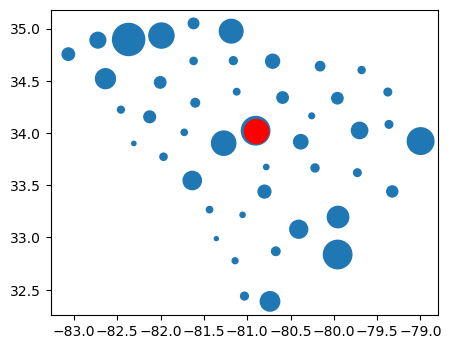

In [66]:
#Plot the faclities (stars) on top of the demand map.
fig, ax = plt.subplots(figsize=(5,5))

SouthCarolina_shp.centroid.plot(ax=ax,markersize=SouthCarolina_shp['2020ESTIMATES']/1000)#markersize is proportional to the population

fac_loc.centroid.plot(ax=ax,color="red",markersize=300)